### import libraries

In [1]:
import numpy as np
import pandas as pd
import os
import glob

import matplotlib.pyplot as plt
import seaborn as sns

import SimpleITK as sitk
from tqdm import tqdm

### read annotations.csv and candidates.csv

In [384]:
data_path = './dataset/'
TRAINDATA_LABELS_FILE = 'traindatalabels.txt'

annot_df = pd.read_csv(data_path + 'CSVFILES/annotations.csv')
cand_df = pd.read_csv(data_path + 'CSVFILES/candidates.csv')
# candv2_df = pd.read_csv('./dataset/CSVFILES/candidates_V2.csv')

### Annotations
##### Columns:
* seriesuid
* coordX
* coordY
* coordZ
* diameter_mm

##### Samples:
<b> 1186 </b> samples

----
----

### Candidates
##### Columns:
* seriesuid
* coordX
* coordY
* coordZ
* class (0 or 1; 1 => cancer)

#### Candidates vs Candidates_V2
<b> 1351 </b> TP in candidates.csv 
|| candidates have <b> 551065 </b> samples


<b> 1557 </b> TP in candidates_V2.csv 
|| candidates_V2 have <b> 754975 </b> samples

### process CT scan

In [195]:
class CT(object):
    def __init__(self, filename = None, coordinates = None):
        self.filename = filename
        self.coordinates = coordinates
        self.itk_img = None
        self.img_arr = None
        
    # Read .mhd/.raw with SimpleITK
    def read_mhd(self):
        path = self.get_mhd_path()
        self.itk_img = sitk.ReadImage(path[0])
        self.img_arr = sitk.GetArrayFromImage(self.itk_img)
         
    def get_mhd_path(self):
        return glob.glob(data_path + '*/' + self.filename + '.mhd')
    
    # Get voxel coordinates
    def get_voxel(self):
        origin = self.get_origin()
        spacing = self.get_spacing()
        coordinates = self.get_coordinates()
        return tuple([np.absolute(coordinates[i] - origin[i]) / spacing[i] for i in range(3)])
    
    def get_coordinates(self):
        return self.coordinates
    
    def get_origin(self):
        return self.itk_img.GetOrigin()
    
    def get_spacing(self):
        return self.itk_img.GetSpacing()
    
    def get_itk_img(self):
        return self.itk_img
    
    def get_image_array(self):
        return self.img_arr

<b> Spacing </b><br> Pixel spacing is measured between the pixel centers <br> and can be different along each dimension

<b> Origin </b><br> The image origin is associated with the coordinates <br> of the first pixel in the image

<b> Voxel </b><br> Voxel coordinates ... <br> ...

In [209]:
pos_ind = cand_df[cand_df['class'] == 1].index # 1351 positives
neg_ind = cand_df[cand_df['class'] == 0].index # 549714 negatives

<b> Test </b>

In [210]:
# name = np.asarray(cand_df.iloc[neg_ind[600]])[0]
# position = np.asarray(cand_df.iloc[neg_ind[600]][1:-1])

# scan = CT(name, position)
# scan.read_mhd()
# print(scan.get_voxel())

### undersample negative class

In [259]:
neg_ind = np.random.choice(neg_ind, len(pos_ind) * 5 , replace = False)
selected_cand_df = cand_df.iloc[list(pos_ind) + list(neg_ind)]

In [261]:
selected_cand_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8106 entries, 13 to 411819
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   seriesuid  8106 non-null   object 
 1   coordX     8106 non-null   float64
 2   coordY     8106 non-null   float64
 3   coordZ     8106 non-null   float64
 4   class      8106 non-null   int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 380.0+ KB


### split to train test val 

In [262]:
from sklearn.model_selection import train_test_split

X = selected_cand_df.iloc[:, :-1]
y = selected_cand_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20)

<b> Serialize and save data </b>

In [263]:
X_train.to_pickle('traindata')
X_val.to_pickle('valdata')
X_test.to_pickle('testdata')

### get proportions

In [271]:
print('TRAINING DATA')
print('Total examples: ', len(y_train))
print('Total positives: ', y_train.sum())
print(format((y_train.sum() / len(y_train)) * 100, '.2f'), '%')

TRAINING DATA
Total examples:  5187
Total positives:  880
16.97 %


### augment data set

<b> Add all the true positive cases two more times </b>

* DF use .set_index
* Series use .reindex

In [322]:
# Augment X set ----------------------
# 1 pass
# take positives
temp_df = X_train[y_train == 1]
# reindex positives
temp_df = temp_df.set_index(temp_df.index + 1000000)
# add new positives
X_train_new = X_train.append(temp_df)

# 2 pass
temp_df = X_train[y_train == 1]
temp_df = temp_df.set_index(temp_df.index + 2000000)
X_train_new = X_train_new.append(temp_df)


# Augment y set ----------------------
# 1 pass
# take positives
temp_df = X_train[y_train == 1]
# reindex positives
temp_df = y_train.reindex(temp_df.index + 1000000)
# set all series values to 1
temp_df.loc[:] = 1
# add new positives
y_train_new = y_train.append(temp_df)

# 2 pass
temp_df = X_train[y_train == 1]
temp_df = y_train.reindex(temp_df.index + 2000000)
temp_df.loc[:] = 1
y_train_new = y_train_new.append(temp_df)

-----

### preprocess images

In [324]:
from skimage.transform import resize
from PIL import ImageEnhance

class PreProcess(object):
    def __init__(self, image = None):
        self.image = image

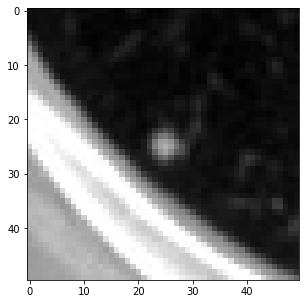

In [330]:
from imageio import imread

img_dir = './img/train/'
plt.figure(figsize = (5, 5))
img = imread(img_dir + 'image_' + str(30517) + '.jpg')
plt.imshow(img, cmap='gray')

----

## CNN

### load image data

In [385]:
train_filenames = X_train_new.index.to_series().apply(lambda x:
                                                      './img/train/image_' + str(x) + '.jpg')

                                            # bytes string literal & integer
traindata = np.zeros(filenames.size, dtype = [('var1', 'S36'), ('var2', int)])
traindata['var1'] = train_filenames.values.astype(str)
traindata['var2'] = y_train_new.values.astype(int)

np.savetxt(TRAINDATA_LABELS_FILE, traindata, fmt="%10s %d")

### build h5py dataset    TODO

In [389]:
import h5py

# f = h5py.File('dataset.hdf5', 'w')

In [390]:
# build_hdf5_image_dataset(dataset_file, image_shape=(50, 50),
#                         mode='file', output_path='traindataset.h5',
#                         categorical_labels=True, normalize=True)
for file, label in traindata:
    pass

### load h5py data

In [406]:
import h5py

h5_train = h5py.File('traindataset.h5', 'r')
X_train_images = h5_train['X']
y_train_labels = h5_train['Y']

h5_val = h5py.File('traindataset.h5', 'r')
X_val_images = h5_val['X']
y_val_labels = h5_val['Y']

### build cnn

In [407]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses

In [408]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [409]:
model.compile(optimizer='adam',
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [411]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [412]:
model.fit(X_train_images, y_train_labels, epochs = 2, 
          validation_data = (X_val_images, y_val_labels))

model.save('nod_model.tf')

#model.fit(X_train_images, Y_train_labels, n_epoch=100, shuffle=True, validation_set=(X_val_images, Y_val_labels),
          #show_metric=True, batch_size=96,snapshot_epoch=True,run_id='nodule-classifier')

# Save model when training is complete to a file
#model.save("nodule-classifier.tfl")

ValueError: Error when checking input: expected conv2d_9_input to have 4 dimensions, but got array with shape (5187, 50, 50)